In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
columns = ['Image_ID',
           'x_centre',
           'y_centre',
           'orientation',
           'corner1_x',
           'corner2_x',
           'corner3_x',
           'corner4_x',
           'corner1_y',
           'corner2_y',
           'corner3_y',
           'corner4_y',
           'class',
           'is_contained',
           'is_occluded']

annotation_file = os.path.join(os.getcwd(), 'annotation1024_cleaned.txt')

In [3]:
data = pd.read_table(annotation_file, delimiter=' ', names=columns)
data.head()

,Image_ID,x_centre,y_centre,orientation,corner1_x,corner2_x,corner3_x,corner4_x,corner1_y,corner2_y,corner3_y,corner4_y,class,is_contained,is_occluded
0,0,580.697942,1009.223279,3.012318,554.0,605.0,607.0,558.0,1004.0,996.0,1016.0,1021.0,2,1,0
1,1,344.827471,812.368939,-0.013888,326.0,363.0,362.0,327.0,806.0,805.0,819.0,819.0,1,1,0
2,1,413.217858,811.243686,-0.011363,392.0,435.0,435.0,390.0,803.0,803.0,818.0,819.0,9,1,0
3,2,606.587345,846.338592,1.446441,593.0,615.0,620.0,598.0,827.0,826.0,866.0,867.0,5,1,0
4,3,877.186248,891.222030,0.013333,839.0,915.0,914.0,840.0,880.0,880.0,903.0,901.0,5,1,0


In [4]:
# Consider only annotations for vehicles that are contained in images
contained_df = data[data['is_contained']==1].copy()
contained_df.shape

(3704, 15)

## To standardise the annotations 
* `<centre_x> <centre_y> <bbox_width> <bbox_height>` - Normalised float values relative to width and height of image, it can be set from 0.0 to 1.0  

* Bounding boxes would be reoriented horizontally and enlarged with new corner points being the min/max x,y coordinates of the existing coordinates. This ensures that the vehicle is within the bounding box and is required as part of yolov7 annotation requirements

* height and width of image are measured based on the min and max x,y coordinates of the enlarged bounding box corners the regardless of orientation. 

In [5]:
def get_img_size(filename):
    with Image.open(filename.values[0]) as img:
        width, height = img.size
        
        return width, height

In [6]:
# Create filename mapping info
contained_df['filepath'] = contained_df['Image_ID'].map(lambda x: os.path.join(os.getcwd(), 'Vehicles', 'CO', str(x).zfill(8) + '_co.png'))
contained_df['annot_for_img_file'] = contained_df['Image_ID'].map(lambda x: str(x).zfill(8) + '.txt')
contained_df.head()

,Image_ID,x_centre,y_centre,orientation,corner1_x,corner2_x,corner3_x,corner4_x,corner1_y,corner2_y,corner3_y,corner4_y,class,is_contained,is_occluded,filepath,annot_for_img_file
0,0,580.697942,1009.223279,3.012318,554.0,605.0,607.0,558.0,1004.0,996.0,1016.0,1021.0,2,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000000.txt
1,1,344.827471,812.368939,-0.013888,326.0,363.0,362.0,327.0,806.0,805.0,819.0,819.0,1,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000001.txt
2,1,413.217858,811.243686,-0.011363,392.0,435.0,435.0,390.0,803.0,803.0,818.0,819.0,9,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000001.txt
3,2,606.587345,846.338592,1.446441,593.0,615.0,620.0,598.0,827.0,826.0,866.0,867.0,5,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000002.txt
4,3,877.186248,891.222030,0.013333,839.0,915.0,914.0,840.0,880.0,880.0,903.0,901.0,5,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000003.txt


In [7]:
contained_df['width'], contained_df['height'] = get_img_size(contained_df['filepath'])

x_coords = ['corner1_x',
           'corner2_x',
           'corner3_x',
           'corner4_x'
           ]

y_coords = ['corner1_y',
           'corner2_y',
           'corner3_y',
           'corner4_y'
           ]

# Create normalised bounding box width and height
contained_df['max_width_norm'] = (contained_df[x_coords].max(axis=1)-contained_df[x_coords].min(axis=1))/contained_df['width']
contained_df['max_height_norm'] = (contained_df[y_coords].max(axis=1)-contained_df[y_coords].min(axis=1))/contained_df['height']
contained_df['x_centre_norm'] = contained_df['x_centre']/contained_df['width']
contained_df['y_centre_norm'] = contained_df['y_centre']/contained_df['height']
contained_df.head()

,Image_ID,x_centre,y_centre,orientation,corner1_x,corner2_x,corner3_x,corner4_x,corner1_y,corner2_y,...,is_contained,is_occluded,filepath,annot_for_img_file,width,height,max_width_norm,max_height_norm,x_centre_norm,y_centre_norm
0,0,580.697942,1009.223279,3.012318,554.0,605.0,607.0,558.0,1004.0,996.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000000.txt,1024,1024,0.051758,0.024414,0.567088,0.985570
1,1,344.827471,812.368939,-0.013888,326.0,363.0,362.0,327.0,806.0,805.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000001.txt,1024,1024,0.036133,0.013672,0.336746,0.793329
2,1,413.217858,811.243686,-0.011363,392.0,435.0,435.0,390.0,803.0,803.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000001.txt,1024,1024,0.043945,0.015625,0.403533,0.792230
3,2,606.587345,846.338592,1.446441,593.0,615.0,620.0,598.0,827.0,826.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000002.txt,1024,1024,0.026367,0.040039,0.592370,0.826503
4,3,877.186248,891.222030,0.013333,839.0,915.0,914.0,840.0,880.0,880.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000003.txt,1024,1024,0.074219,0.022461,0.856627,0.870334


As the class labels are not continuous which is required for YOLOv7 model, some adjustments are needed. For simplicity, we will use class labels starting from 1 and ending with 9, while classifying bus and motorbikes as others under new label for simplicity.

|Given vehicle type|Total(paper from cross-val)|Closest annotation counts(unaccounted)|Deduced class number(s) from closest count|New class label after mapping|
|---|---|---|---|---|
|Boat|170|171(1)|23|3| 
|Camping (Van)|390|397(7)|5|5|
|Car|1340|1377(37)|1|1|
|Others|200|204(4)|10|8|
|Pickup|950|955(5)|11|6|
|Plane|47|48(1)|31|7|
|Tractor|190|190(0)|4|4|
|Truck|300|307(7)|2|2|
|Vans|100|101(1)|9|9|
|Bus(Not stated)|0|3(3)|8|8|
|Motorbike(Not stated)|0|4(4)|7|8|

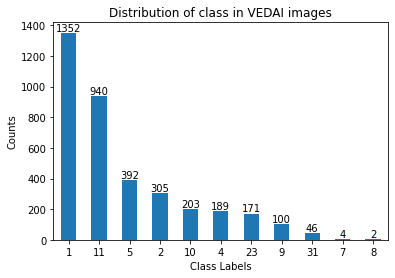

In [8]:
ax = contained_df['class'].value_counts().plot(kind='bar', 
                                  rot=0, 
                                  title='Distribution of class in VEDAI images'
                                 );
ax.set_xlabel("Class Labels")
ax.set_ylabel("Counts")
for container in ax.containers:
    ax.bar_label(container)

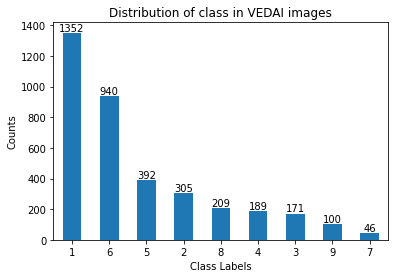

In [9]:
# Apply new mapping
new_data = { 1:1,
             2:2,
             4:4,
             5:5,
             7:8,
             8:8,
             9:9,
             10:8,
             11:6,
             23:3,
             31:7
           }
  

contained_df['class'] = contained_df['class'].replace(new_data)
ax = contained_df['class'].value_counts().plot(kind='bar', 
                                  rot=0, 
                                  title='Distribution of class in VEDAI images'
                                 );
ax.set_xlabel("Class Labels")
ax.set_ylabel("Counts")
for container in ax.containers:
    ax.bar_label(container)

In [10]:
new_annot_dir = os.path.join(os.getcwd(), 'annotations_processed')
if not os.path.exists(new_annot_dir):
      
    # if the existing directory is not present 
    # then create it.
    os.makedirs(new_annot_dir)

In [11]:
contained_df.head()

,Image_ID,x_centre,y_centre,orientation,corner1_x,corner2_x,corner3_x,corner4_x,corner1_y,corner2_y,...,is_contained,is_occluded,filepath,annot_for_img_file,width,height,max_width_norm,max_height_norm,x_centre_norm,y_centre_norm
0,0,580.697942,1009.223279,3.012318,554.0,605.0,607.0,558.0,1004.0,996.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000000.txt,1024,1024,0.051758,0.024414,0.567088,0.985570
1,1,344.827471,812.368939,-0.013888,326.0,363.0,362.0,327.0,806.0,805.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000001.txt,1024,1024,0.036133,0.013672,0.336746,0.793329
2,1,413.217858,811.243686,-0.011363,392.0,435.0,435.0,390.0,803.0,803.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000001.txt,1024,1024,0.043945,0.015625,0.403533,0.792230
3,2,606.587345,846.338592,1.446441,593.0,615.0,620.0,598.0,827.0,826.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000002.txt,1024,1024,0.026367,0.040039,0.592370,0.826503
4,3,877.186248,891.222030,0.013333,839.0,915.0,914.0,840.0,880.0,880.0,...,1,0,/mnt/c/Users/quekz/OneDrive/Desktop/Vedai-Yolo...,00000003.txt,1024,1024,0.074219,0.022461,0.856627,0.870334


In [12]:
# Utilise only relevant columns
col_interest = ['annot_for_img_file','class','x_centre_norm','y_centre_norm','max_width_norm','max_height_norm']
contained_df = contained_df[col_interest]
contained_df.head()

,annot_for_img_file,class,x_centre_norm,y_centre_norm,max_width_norm,max_height_norm
0,00000000.txt,2,0.567088,0.985570,0.051758,0.024414
1,00000001.txt,1,0.336746,0.793329,0.036133,0.013672
2,00000001.txt,9,0.403533,0.792230,0.043945,0.015625
3,00000002.txt,5,0.592370,0.826503,0.026367,0.040039
4,00000003.txt,5,0.856627,0.870334,0.074219,0.022461


In [13]:
annot_files_for_img = set(contained_df['annot_for_img_file'])
annot_files_for_img 

{'00001140.txt',
 '00000278.txt',
 '00000499.txt',
 '00001064.txt',
 '00000268.txt',
 '00001173.txt',
 '00000066.txt',
 '00000187.txt',
 '00001165.txt',
 '00000043.txt',
 '00001260.txt',
 '00000325.txt',
 '00000473.txt',
 '00000319.txt',
 '00000599.txt',
 '00000801.txt',
 '00000321.txt',
 '00000593.txt',
 '00000576.txt',
 '00001068.txt',
 '00000746.txt',
 '00001133.txt',
 '00001205.txt',
 '00000930.txt',
 '00001199.txt',
 '00000383.txt',
 '00000060.txt',
 '00000110.txt',
 '00000239.txt',
 '00000162.txt',
 '00000478.txt',
 '00000290.txt',
 '00001161.txt',
 '00000346.txt',
 '00000556.txt',
 '00000378.txt',
 '00000741.txt',
 '00001062.txt',
 '00001197.txt',
 '00000022.txt',
 '00000203.txt',
 '00001206.txt',
 '00000117.txt',
 '00000457.txt',
 '00001005.txt',
 '00000649.txt',
 '00000672.txt',
 '00000820.txt',
 '00001004.txt',
 '00000682.txt',
 '00000555.txt',
 '00001163.txt',
 '00000084.txt',
 '00000914.txt',
 '00000210.txt',
 '00000653.txt',
 '00000678.txt',
 '00000570.txt',
 '00000951.txt

In [14]:
contained_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3704 entries, 0 to 3756
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   annot_for_img_file  3704 non-null   object 
 1   class               3704 non-null   int64  
 2   x_centre_norm       3704 non-null   float64
 3   y_centre_norm       3704 non-null   float64
 4   max_width_norm      3704 non-null   float64
 5   max_height_norm     3704 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 202.6+ KB


In [15]:
for img_id in annot_files_for_img :
    temp_df= contained_df[contained_df['annot_for_img_file']==img_id].drop('annot_for_img_file', axis=1)
    txt_save_path = os.path.join(new_annot_dir, img_id)
    txt_format = ['%d', '%f', '%f', '%f', '%f']
    np.savetxt(txt_save_path, temp_df.values, fmt=txt_format, delimiter=" ")  